In [0]:
# import modules we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import datetime

from sklearn import model_selection, preprocessing
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import math

In [63]:
# read data
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

df = pdr.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-05,213.970001,211.509995,212.000000,213.279999,23913700.0,213.279999
2019-09-06,214.419998,212.509995,214.050003,213.259995,19362300.0,213.259995
2019-09-09,216.440002,211.070007,214.839996,214.169998,27309400.0,214.169998
2019-09-10,216.779999,211.710007,213.860001,216.699997,31777900.0,216.699997
2019-09-11,223.710007,217.729996,218.070007,223.589996,43590900.0,223.589996


In [64]:
# see shape
df.shape

(2439, 6)

In [65]:
# create df for regression
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,26.681330,123432400.0,0.990606,0.271752
2010-01-05,26.727465,150476200.0,1.091520,-0.102519
2010-01-06,26.302330,138040000.0,2.123523,-1.590633
2010-01-07,26.253704,119282800.0,1.400893,-0.552538
2010-01-08,26.428249,111902700.0,1.386924,0.798864


In [66]:
# clean data

# drop missing values
dfreg.fillna(value=-99999, inplace=True)

# separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# separate the label, want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# scale the X to even distribution for linear regression
X = preprocessing.scale(X)

# find data series of late X and early X (train) for model gen and eval
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Shape X', X.shape)
print('Shape y', y.shape)

Shape X (2414, 4)
Shape y (2414,)


In [0]:
# create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [68]:
# build Linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
# build ridge regression model
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [70]:
# build lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [71]:
# build polynomial 2 regression model
poly2 = make_pipeline(PolynomialFeatures(2), Ridge())
poly2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [72]:
# build polynomial 3 regression model
poly3 = make_pipeline(PolynomialFeatures(3), Ridge())
poly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [73]:
# get confidence scores
lin_reg_conf = lin_reg.score(X_test, y_test)
ridge_conf = ridge.score(X_test, y_test)
lasso_conf = lasso.score(X_test, y_test)
poly2_conf = poly2.score(X_test, y_test)
poly3_conf = poly3.score(X_test, y_test)

# print results
print('LinReg confidence is: ', lin_reg_conf * 100)
print('Ridge confidence is: ', ridge_conf * 100)
print('Lasso confidence is: ', lasso_conf * 100)
print('Poly 2 confidence is: ', poly2_conf * 100)
print('Poly 3 confidence is: ', poly3_conf * 100)

LinReg confidence is:  96.75188331660755
Ridge confidence is:  96.75170227453532
Lasso confidence is:  96.7467548689118
Poly 2 confidence is:  96.77861785245004
Poly 3 confidence is:  96.90414639954803


In [79]:
# create forecasts
lin_reg_forecast = lin_reg.predict(X_lately)
ridge_forecast = ridge.predict(X_lately)
lasso_forecast = lasso.predict(X_lately)
poly2_forecast = poly2.predict(X_lately)
poly3_forecast = poly3.predict(X_lately)

# print shape
print(lin_reg_forecast.shape)

(25,)


In [83]:
# append forecasts to dataframe

# linear regression
dfreg['Forecast_LinReg'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in lin_reg_forecast:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns))]
    dfreg['Forecast_LinReg'].loc[next_date] = i

# ridge
dfreg['Forecast_Ridge'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in ridge_forecast:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns))]
    dfreg['Forecast_Ridge'].loc[next_date] = i

# lasso
dfreg['Forecast_Lasso'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in lasso_forecast:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns))]
    dfreg['Forecast_Lasso'].loc[next_date] = i

# poly2
dfreg['Forecast_Poly2'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in poly2_forecast:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns))]
    dfreg['Forecast_Poly2'].loc[next_date] = i

# poly3
dfreg['Forecast_Poly3'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in poly3_forecast:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns))]
    dfreg['Forecast_Poly3'].loc[next_date] = i

dfreg.shape

(2614, 10)

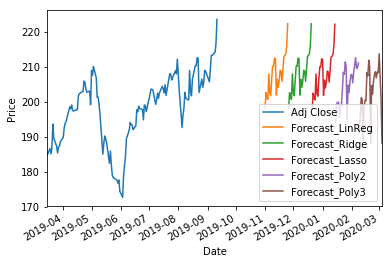

In [85]:
# plot prediction
dfreg['Adj Close'].tail(300).plot()
dfreg['Forecast_LinReg'].tail(300).plot()
dfreg['Forecast_Ridge'].tail(300).plot()
dfreg['Forecast_Lasso'].tail(300).plot()
dfreg['Forecast_Poly2'].tail(300).plot()
dfreg['Forecast_Poly3'].tail(300).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()